<a href="https://colab.research.google.com/github/ivonnelinares10-prog/2025IIMLAceleradores/blob/main/MLEAIvHubMetricsRedesN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="center">
  <img src="https://www.dropbox.com/scl/fi/fqv8wxrh2fzpp9nudoum8/LogoEscuela.png?rlkey=g2keqeitv28yzatqs75odkqbq&st=k1urhxs6&dl=1" alt="Logo Escuela" width="200">
</p>

#Machine Learning Methods Applied to Real-World Data Coursework for the Machine Learning class, Data Science Master's Program, Escuela Colombiana de Ingeniería Julio Garavito. Bogotá D.C.

**Profesores:** <br>
Ivan Olier Caparroso <br>
Mario Julian Cañon Ayala <br>


**Estudiantes:** <br>
Huber Camilo Borja Amaya <br>
Ivonne Elena Linares Cortés <br>


**2025 Semestre 2**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score, roc_auc_score

from sklearn.utils.class_weight import compute_class_weight


import tensorflow as tf
from tensorflow.keras import layers, models, callbacks


In [ ]:
base = 'https://raw.githubusercontent.com/ivonnelinares10-prog/2025_II_MLAceleradores/main/'

signals = pd.read_csv(base + 'signals.csv')
signals_kaggle = pd.read_csv(base + 'signals_kaggle.csv')
signals_test = pd.read_csv(base + 'signals_test.csv')
metadata = pd.read_csv(base + 'metadata.csv')
metadata_kaggle = pd.read_csv(base + 'metadata_kaggle.csv')


In [ ]:
signals.shape

(629866, 5)

In [ ]:
signals.columns

Index(['user_snippet', 'x-axis', 'y-axis', 'z-axis', 'timestamp'], dtype='object')

In [ ]:
signals_kaggle.shape

(250184, 5)

In [ ]:
signals_kaggle.columns

Index(['user_snippet', 'x-axis', 'y-axis', 'z-axis', 'timestamp'], dtype='object')

In [ ]:
signals_test.shape

(193273, 5)

In [ ]:
signals_test.columns

Index(['user_snippet', 'x-axis', 'y-axis', 'z-axis', 'timestamp'], dtype='object')

## Convolutional Neural Network unidimensional CNN 1D

Pasos Fuente: ayuda de ChatGPT y Copilot.

In [ ]:
data = signals.merge(
    metadata[['user_snippet', 'activity']],
    on='user_snippet',
    how='inner'
)

data.head()

,user_snippet,x-axis,y-axis,z-axis,timestamp,activity
0,525_0,1.57,-0.61,-0.65,0.0,Jogging
1,525_0,-1.12,1.84,-1.46,50.0,Jogging
2,525_0,5.48,14.14,-5.71,100.0,Jogging
3,525_0,-12.41,10.53,-5.52,150.0,Jogging
4,525_0,-1.14,10.50,2.91,200.0,Jogging


In [ ]:
# Número de pasos de tiempo por fragmento o snippet
pasos = 100

# Agrupar por user_snippet
grupos = data.groupby('user_snippet')

X_lista = []
y_lista = []

# Procesar cada grupo
for snippet_id, grupo in grupos:

    arr = grupo[['x-axis', 'y-axis', 'z-axis']].values
    if len(arr) >= pasos:
        arrfijo = arr[:pasos]

    else:
        faltantes = pasos - len(arr)
        pad = np.zeros((faltantes, 3))
        arrfijo = np.vstack([arr, pad])

    X_lista.append(arrfijo)
    y_lista.append(grupo['activity'].iloc[0])



# Convertir listas en arreglos finales
X = np.stack(X_lista)   # shape: (n_snippets, pasos, 3)
y_cruda = np.array(y_lista)

print(X.shape, y_cruda.shape)

(6310, 100, 3) (6310,)


In [ ]:
# Ponerle código a las clases
le = LabelEncoder()
y = le.fit_transform(y_cruda)   # 0,1,2,3,4,5

cantidad_clases = len(le.classes_)
print("Clases:", list(le.classes_))
print("Número de clases:", cantidad_clases)


Clases: [np.str_('Downstairs'), np.str_('Jogging'), np.str_('Sitting'), np.str_('Standing'), np.str_('Upstairs'), np.str_('Walking')]
Número de clases: 6


In [ ]:
# Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

X_train.shape, X_val.shape


((4732, 100, 3), (1578, 100, 3))

In [ ]:
# Definir Modelo

modeloCNN=models.Sequential([
layers.Input(shape=(pasos,3)),

layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'), # aprende de 35 patrones, ejemplo, movimiento vertical, horizontal...
layers.MaxPooling1D(pool_size=2),

layers.Conv1D(64, kernel_size=5, activation='relu', padding='same'), # kernel = filtro deslizante que recorre la serie temporal y extrae patrones. 5 timestamps consecutivos o 100 puntos por snippet
layers.MaxPooling1D(pool_size=2), # reduce la resolución temporal tomando solo los valores mayores (100 pasos a 50 pasos)

layers.Flatten(), # convierte 3D a 1D
layers.Dense(64, activation='relu'), # aprente de 64 patrones - dense aprende patrones no lineales de alto nivel de los patrones extraídos de 6 actividades humanas
layers.Dense(cantidad_clases, activation='softmax')
])
modeloCNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modeloCNN.summary()

# padding = same es para que la salida tenga el mismo tamaño de la entrada (100 pasos)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 100, 32)        │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,478 (443.27 KB)

 Trainable params: 113,478 (443.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compilar y entrenar
modeloCNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = modeloCNN.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64, verbose=1)

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5612 - loss: 1.4446 - val_accuracy: 0.8010 - val_loss: 0.5663
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8328 - loss: 0.4852 - val_accuracy: 0.8403 - val_loss: 0.4345
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8730 - loss: 0.3403 - val_accuracy: 0.8707 - val_loss: 0.3310
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9105 - loss: 0.2392 - val_accuracy: 0.8720 - val_loss: 0.3253
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9401 - loss: 0.1802 - val_accuracy: 0.8745 - val_loss: 0.3159
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9463 - loss: 0.1620 - val_accuracy: 0.8973 - val_loss: 0.2789
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9569 - loss: 0.1318 - val_accuracy: 0.9132 - val_loss: 0.2685
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9682 - loss: 0.0976 - val_accuracy: 0.9113 - v

In [ ]:
# Evaluación, matriz y reporte

# Predicciones de probabilidad y de clase
y_val_proba = modeloCNN.predict(X_val)
y_val_pred  = y_val_proba.argmax(axis=1)

print("Matriz de confusión (validación)")
print(confusion_matrix(y_val, y_val_pred))

print("\n Reporte de clasificación (validación) ")
print(classification_report(
    y_val,
    y_val_pred,
    target_names=le.classes_
))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Matriz de confusión (validación)
[[115   2   0   0  18  17]
 [  1 482   0   0   1   4]
 [  0   0  80   0   0   0]
 [  0   0   1  68   0   0]
 [ 18   8   0   0 138  12]
 [  5   1   0   0   7 600]]

 Reporte de clasificación (validación) 
              precision    recall  f1-score   support

  Downstairs       0.83      0.76      0.79       152
     Jogging       0.98      0.99      0.98       488
     Sitting       0.99      1.00      0.99        80
    Standing       1.00      0.99      0.99        69
    Upstairs       0.84      0.78      0.81       176
     Walking       0.95      0.98      0.96       613

    accuracy                           0.94      1578
   macro avg       0.93      0.92      0.92      1578
weighted avg       0.94      0.94      0.94      1578



In [ ]:
cross_entropy_loss = tf.keras.losses.sparse_categorical_crossentropy(y_val, y_val_proba)
print(f"Sparse Categorical Cross-Entropy on validation set: {cross_entropy_loss.numpy().mean():.4f}")

Sparse Categorical Cross-Entropy on validation set: 0.2550


In [ ]:
# Lista de IDs de snippets
ids_kaggle = metadata_kaggle['user_snippet'].values
X_kaggle_list = []

# Número de pasos por fragmento
pasos = 100

# Procesar cada snippet
for snippet_id in ids_kaggle:
    grupo = signals_kaggle[signals_kaggle['user_snippet'] == snippet_id]
    arr = grupo[['x-axis', 'y-axis', 'z-axis']].values

    if len(arr) >= pasos:
        arrfijo = arr[:pasos]
    elif len(arr) == 0:
        arrfijo = np.zeros((pasos, 3))
    else:
        faltantes = pasos - len(arr)
        pad = np.zeros((faltantes, 3))
        arrfijo = np.vstack([arr, pad])

    X_kaggle_list.append(arrfijo)

# Convertir a arreglo 3D
X_kaggle = np.stack(X_kaggle_list)

# Mostrar dimensiones
print(X_kaggle.shape)
print(ids_kaggle.shape)


(2506, 100, 3)
(2506,)


In [ ]:
# Predicción y decodificar etiquetas

# Obtener probabilidades de cada clase
y_kaggle_proba = modeloCNN.predict(X_kaggle)

# Clase predicha (índice de la probabilidad máxima)
y_kaggle_int = y_kaggle_proba.argmax(axis=1)

# Volver a etiquetas originales de actividad
y_kaggle_labels = le.inverse_transform(y_kaggle_int)

print("Ejemplo de predicciones:", y_kaggle_labels[:10])

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Ejemplo de predicciones: ['Walking' 'Sitting' 'Walking' 'Standing' 'Walking' 'Downstairs' 'Sitting'
 'Walking' 'Downstairs' 'Downstairs']


In [ ]:
# Archivo Kaggle

pred_df = pd.DataFrame({
    'user_snippet': ids_kaggle,
    'prediction': y_kaggle_labels
})

print(pred_df.head())
print(pred_df.shape)   # debería ser (2506, 2)

pred_df.to_csv('predictions_IvHubMetrics.csv', index=False)

  user_snippet prediction
0       8054_0    Walking
1       8054_1    Sitting
2       8054_2    Walking
3       8054_3   Standing
4       8054_4    Walking
(2506, 2)


## Convolutional Neural Network unidimensional CNN +  Long Short-Term Memory LSTM

LSTM es una red neuronal diseñada prar trabajar con secuencias de datos y series temporales.

In [ ]:
# Dimensiones del input
pasos = X_train.shape[1]       # 100
actividades = X_train.shape[2]  # 3

# Número de clases
num_clases = len(np.unique(y_train))   # O usa len(le.classes_) si tienes labelencoder

# Modelo CNN + LSTM
modelo_cnn_lstm = models.Sequential([
    layers.Input(shape=(pasos, actividades)),   #Capa entrada

    # CNN - Extracción de características locales
    layers.Conv1D(32, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(64, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),

    # LSTM - Memoria secuencial
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64, return_sequences=False),

    # Clasificación: capa salida
    layers.Dense(num_clases, activation='softmax')
])

# Compilar
modelo_cnn_lstm.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

modelo_cnn_lstm.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 100, 32)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 50, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 25, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,254 (301.77 KB)

 Trainable params: 77,254 (301.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
clases = np.unique(y_train)
pesos = compute_class_weight(
    class_weight='balanced',
    classes=clases,
    y=y_train
)
class_weight = dict(zip(clases, pesos))
print(class_weight)

{np.int64(0): np.float64(1.737151248164464), np.int64(1): np.float64(0.5390749601275917), np.int64(2): np.float64(3.272475795297372), np.int64(3): np.float64(3.7735247208931417), np.int64(4): np.float64(1.4993662864385298), np.int64(5): np.float64(0.4288562624614827)}


In [ ]:
# Entrenamiento
es = callbacks.EarlyStopping(       # para evitar overfitting
    monitor='val_loss',             # vigilar pérdida en función de validación > sparse categorical crossentropy del set de validación
    patience=5,                     # número de épocas
    restore_best_weights=True       # los pesos del modelo se restauran automáticamente a los de mejor época
)

history_cnn_lstm = modelo_cnn_lstm.fit(
    X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=64,
    callbacks=[es],                 # llama devuelta
    class_weight=class_weight,
    verbose=1
)

Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.5683 - loss: 1.1786 - val_accuracy: 0.7326 - val_loss: 0.6512
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.8018 - loss: 0.5619 - val_accuracy: 0.8219 - val_loss: 0.5082
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8350 - loss: 0.4599 - val_accuracy: 0.8283 - val_loss: 0.4397
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.8617 - loss: 0.3866 - val_accuracy: 0.8213 - val_loss: 0.4738
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.8724 - loss: 0.3546 - val_accuracy: 0.8802 - val_loss: 0.3501
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9014 - loss: 0.3169 - val_accuracy: 0.8878 - val_loss: 0.3282
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8994 - loss: 0.2656 - val_accuracy: 0.9347 - val_loss: 0.2089
Epoch 8/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9367 - loss: 0.1959 - val_accuracy: 0.9436 - 

In [ ]:
# Probabilidades y clases predichas
y_val_proba_cnn_lstm = modelo_cnn_lstm.predict(X_val)
y_val_pred_cnn_lstm  = y_val_proba_cnn_lstm.argmax(axis=1)

print(" Matriz de confusión CNN+LSTM ")
print(confusion_matrix(y_val, y_val_pred_cnn_lstm))

print("\n Reporte de clasificación CNN+LSTM ")
print(classification_report(
    y_val,
    y_val_pred_cnn_lstm,
    target_names=le.classes_
))


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 Matriz de confusión CNN+LSTM 
[[137   2   0   0  13   0]
 [  1 482   0   0   4   1]
 [  0   0  80   0   0   0]
 [  0   0   2  67   0   0]
 [  8   4   0   0 164   0]
 [  6   0   0   0  10 597]]

 Reporte de clasificación CNN+LSTM 
              precision    recall  f1-score   support

  Downstairs       0.90      0.90      0.90       152
     Jogging       0.99      0.99      0.99       488
     Sitting       0.98      1.00      0.99        80
    Standing       1.00      0.97      0.99        69
    Upstairs       0.86      0.93      0.89       176
     Walking       1.00      0.97      0.99       613

    accuracy                           0.97      1578
   macro avg       0.95      0.96      0.96      1578
weighted avg       0.97      0.97      0.97      1578



In [ ]:
# Preparar para Kaggle
ids_kaggle = metadata_kaggle['user_snippet'].values

X_kaggle_list = []

for snippet_id in ids_kaggle:
    grupo = signals_kaggle[signals_kaggle['user_snippet'] == snippet_id]
    arr = grupo[['x-axis', 'y-axis', 'z-axis']].values

    if len(arr) == 0:
        arr_fijo = np.zeros((pasos, 3))
    elif len(arr) >= pasos:
        arr_fijo = arr[:pasos]
    else:
        faltan = pasos - len(arr)
        pad = np.zeros((faltan, 3))
        arr_fijo = np.vstack([arr, pad])

    X_kaggle_list.append(arr_fijo)

X_kaggle = np.stack(X_kaggle_list)
print("X_kaggle:", X_kaggle.shape)   # (2506, 100, 3)


X_kaggle: (2506, 100, 3)


In [ ]:
# Predicciones y probabilidades

# Probabilidades por clase
y_val_proba = modelo_cnn_lstm.predict(X_val)

# Clase predicha (índice del máximo)
y_val_pred = y_val_proba.argmax(axis=1)

print("Primeras predicciones:", y_val_pred[:10])
print("Primeras etiquetas reales:", y_val[:10])


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Primeras predicciones: [5 1 1 4 1 5 1 4 1 5]
Primeras etiquetas reales: [5 1 1 4 1 5 1 4 1 5]


In [ ]:
# Probabilidades Kaggle
y_kaggle_proba_cnn_lstm = modelo_cnn_lstm.predict(X_kaggle)

# Índice de la clase más probable
y_kaggle_int_cnn_lstm = y_kaggle_proba_cnn_lstm.argmax(axis=1)

# Volver a etiquetas originales (Walking, Jogging, etc.)
y_kaggle_labels_cnn_lstm = le.inverse_transform(y_kaggle_int_cnn_lstm)

print("Ejemplo de predicciones CNN+LSTM:", y_kaggle_labels_cnn_lstm[:10])

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Ejemplo de predicciones CNN+LSTM: ['Walking' 'Sitting' 'Walking' 'Standing' 'Walking' 'Downstairs' 'Sitting'
 'Walking' 'Walking' 'Walking']


In [ ]:
pred_cnn_lstm_df = pd.DataFrame({
    'user_snippet': ids_kaggle,
    'prediction': y_kaggle_labels_cnn_lstm
})

print(pred_cnn_lstm_df.head())
print(pred_cnn_lstm_df.shape)  # debería ser (2506, 2)

pred_cnn_lstm_df.to_csv('predictions_IvHubMetrics.csv', index=False)


  user_snippet prediction
0       8054_0    Walking
1       8054_1    Sitting
2       8054_2    Walking
3       8054_3   Standing
4       8054_4    Walking
(2506, 2)


In [ ]:
# Métricas Globales

acc = accuracy_score(y_val, y_val_pred)
bacc = balanced_accuracy_score(y_val, y_val_pred)

print(f"Accuracy global CNN+LSTM: {acc:.4f}")
print(f"Balanced accuracy CNN+LSTM: {bacc:.4f}")


Accuracy global CNN+LSTM: 0.9677
Balanced accuracy CNN+LSTM: 0.9610


In [ ]:
# Binarizar etiquetas reales
y_val_bin = label_binarize(y_val, classes=np.arange(num_clases))

# AUC macro one-vs-rest
macro_auc = roc_auc_score(y_val_bin, y_val_proba, average='macro', multi_class='ovr')
print(f"AUC (macro, OVR) CNN+LSTM: {macro_auc:.4f}")


AUC (macro, OVR) CNN+LSTM: 0.9975


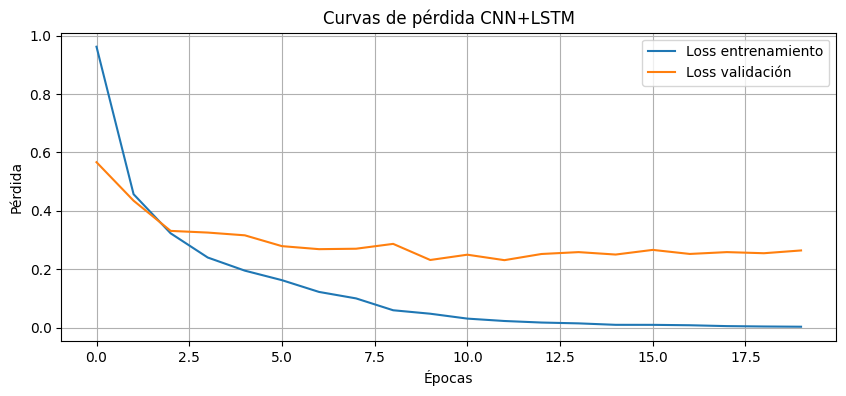

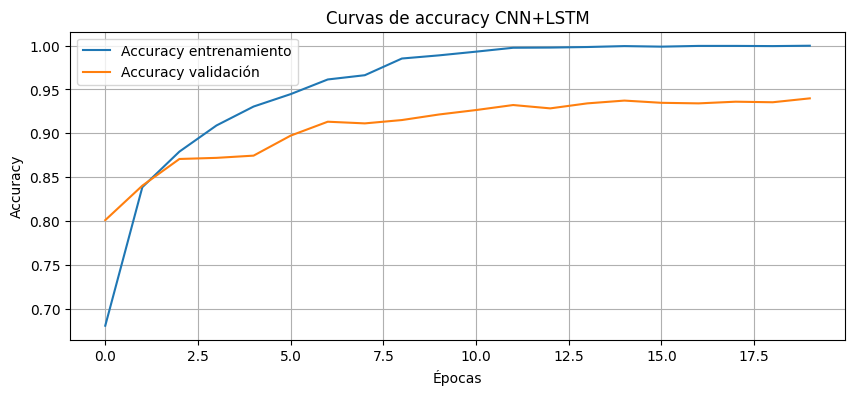

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Loss entrenamiento')
plt.plot(history.history['val_loss'], label='Loss validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Curvas de pérdida CNN+LSTM')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Accuracy entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy validación')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.title('Curvas de accuracy CNN+LSTM')
plt.legend()
plt.grid(True)
plt.show()


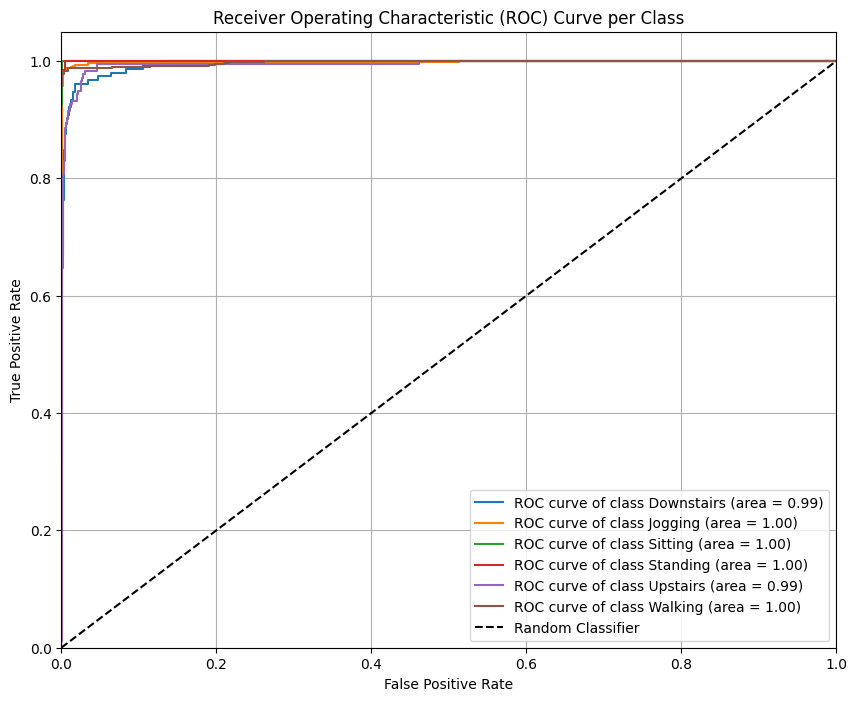

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

# Plot ROC curve for each class
for i, class_name in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_val_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve of class {class_name} (area = {roc_auc:.2f})')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve per Class')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
cross_entropy_loss_cnn_lstm = tf.keras.losses.sparse_categorical_crossentropy(y_val, y_val_proba_cnn_lstm)
print(f"Sparse Categorical Cross-Entropy on validation set (CNN+LSTM): {cross_entropy_loss_cnn_lstm.numpy().mean():.4f}")

Sparse Categorical Cross-Entropy on validation set (CNN+LSTM): 0.1093
